## Regression Preparation With Basic Methods

For this example, we're going to to take the simplest approach to combining all the data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fname_train = 'data/train.csv'
fname_test = 'data/test.csv'
fname_macro = 'data/macro.csv'

In [3]:
df_train = pd.read_csv(fname_train)
df_test = pd.read_csv(fname_test)
df_macro = pd.read_csv(fname_macro)

### Data Processing

Pull in all the data, combine it, take a look at some stats and do very basic preparation (with no real feature engineering).

In [6]:
df_train_merge = pd.merge(df_train, df_macro, how='left', on='timestamp')
print(df_train_merge.shape)
df_train_merge.head()

(30471, 391)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


### Processing the Target Variable

First, let's sort out our predicted value. Often in housing price datasets, there is a lot of skewness in the value to predict. Taking a log gives a more normal distribution. This tends to lead to less bias in the regression.

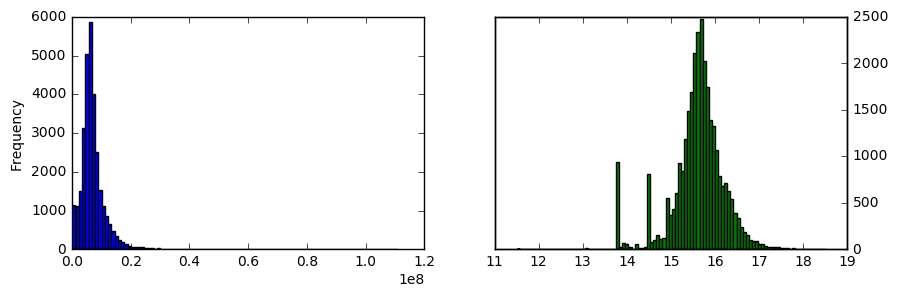

In [9]:
target = df_train_merge['price_doc']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

target.plot(ax=axes[0], kind='hist', bins=100)
np.log(target).plot(ax=axes[1], kind='hist', bins=100, color='green', secondary_y=True)
plt.show()

Appears same thing is present in this data - so prediction variable will be log(house price)

In [10]:
y = np.log(target)

### Processing input features

Based on just top of the dataset, we can see there are plenty of missing values in some columns. Let's see how bad the problem is. Since we have 390 features, we'll most likely be able to discard some features with many missing values.

We can always come up with ways to add them in later.

In [11]:
percent_null = df_train_merge.isnull().mean(axis=0) > 0.20
print("{:.2%} of columns have more than 20% missing values.".format(np.mean(percent_null)))

5.63% of columns have more than 20% missing values.


I'm happy to lose 5% of features and not have to worry about a proper imputation strategy. We'll also pull out the uninformative columns.

In [12]:
df_train_clean = df_train_merge.loc[:, ~percent_null]
df_train_clean = df_train_clean.drop(['id', 'price_doc'], axis=1)

In [14]:
print(df_train_clean.dtypes.value_counts())
np.array([c for c in df_train_clean.columns if df_train_clean[c].dtype == 'object'])

float64    191
int64      157
object      19
dtype: int64


array(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion',
       'detention_facility_raion', 'water_1line', 'big_road1_1line',
       'railroad_1line', 'ecology', 'child_on_acc_pre_school',
       'modern_education_share', 'old_education_build_share'], 
      dtype='<U25')

The next question is how to handle the object data types. I'm going ot make the basic assumption that all floating and integer valued colums can be treated as one-dimensional values, so there is no need to dummy these.

It's possible that you could do better processing on some of the object columns - for example, 'sub_area' could be replaced with a 2D coordinate vector of the area, so distance metrics make sense between each class. However, I'm just going to dummy every object variable except 'timestamp'. I'll replace 'timestamp' with a numeric value, since it makes sense to treat this as 1-dimensional and the distance is well-defined.

In [15]:
df_train_clean['timestamp'] = pd.to_numeric(pd.to_datetime(df_train_clean['timestamp'])) / 1e18
print(df_train_clean['timestamp'].head())

0    1.313798
1    1.314058
2    1.314403
3    1.314835
4    1.315181
Name: timestamp, dtype: float64


In [16]:
# This automatically only dummies object columns
df_train_clean = pd.get_dummies(df_train_clean).astype(np.float64)
print(df_train_clean.shape)

(30471, 536)


In [17]:
X = df_train_clean

We have 536 features and 30,471 total observation at this point. Since the number of features is low, the challenge is going to be finding a model with high capacity, rather than necessarily adding lots of regularization at this stage. Not worried about overfitting yet.

Let's prepare the data for learning. To do this, we'll follow basic steps:

1. Make a train/test split
2. Impute values for the missing values - we will replace with the mean
3. Scale every value by mean and standard deviation.

We are going to use the imputer class from sklearn - this doesn't support different imputing methods for different coumns. Ideally for the [0,1] values we converted from strings, you would use the mode, but for the continuous you would use the mean. You could write a class to implement this, but again this is just a rough and ready approach.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline

# Make a pipeline that transforms X
pipeline = make_pipeline(Imputer(), StandardScaler())
pipeline.fit(X_train)
pipeline.transform(X_train)

array([[-0.24111955,  1.17119378,  3.08833722, ...,  1.68270601,
        -0.90219755, -0.34434811],
       [ 1.04279123,  0.58325276,  2.89938436, ..., -0.59428087,
         1.1084047 , -0.34434811],
       [ 0.65732148, -0.10267843, -0.87967294, ..., -0.59428087,
         1.1084047 , -0.34434811],
       ..., 
       [ 0.09097747,  0.63224784,  1.38776144, ..., -0.59428087,
         1.1084047 , -0.34434811],
       [-0.05431498,  0.24028716,  1.00985571, ...,  1.68270601,
        -0.90219755, -0.34434811],
       [ 0.31632901, -0.42114648,  0.63194998, ..., -0.59428087,
         1.1084047 , -0.34434811]])

Finally, we want a single real-valued metric for comparing models and implementations. Kaggle tells us the metric - RMSLE (Root Mean Squared Log Error).

For convenience, will take exponential in this function since the model is working in log(house price).

In [20]:
from sklearn.metrics import make_scorer

In [21]:
def rmsle_exp(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(np.mean(np.power(np.log(y_true + 1) - np.log(y_pred + 1), 2)))

In [22]:
def score_model(model, pipe):
    train_error = rmsle_exp(y_train, model.predict(pipe.transform(X_train)))
    test_error = rmsle_exp(y_test, model.predict(pipe.transform(X_test)))
    return train_error, test_error

Now we have everything we need for making predictions. Let's fit a basic linear model. Expect to underfit the data.

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
lr = LinearRegression(fit_intercept=True)
lr.fit(pipeline.transform(X_train), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
print("Train error: {:.4f}, Test error: {:.4f}".format(*score_model(lr, pipeline)))

Train error: 0.5126, Test error: 0.5075


This is close to the benchmark level for the competition.

Let's look at a few more "out-of-box" methods - SVR, Random Forests, and XGBoost.

SVR allows for nice non-linearities if you use the Guassian kernel. The downside is it takes a long time to fit the data. You should also run cross=validation on the parameters C (the regularization parameters) and what sklearn calls 'gamma', the standard deviation of the kernel. 

Note - due to high runtime, maybe don't run SVR, it performs worse than random forests but better than linear regression

In [26]:
"""
from sklearn.svm import SVR

svr = SVR()
svr.fit(pipeline.transform(X_train), y_train)

print("Train error: {:.4f}, Test error: {:.4f}".format(*score_model(svr, pipeline)))
"""

'\nfrom sklearn.svm import SVR\n\nsvr = SVR()\nsvr.fit(pipeline.transform(X_train), y_train)\n\nprint("Train error: {:.4f}, Test error: {:.4f}".format(*score_model(svr, pipeline)))\n'

Next up are tree models - will use same n_estimators. Random forests will overfit until you set min_samples_leaf to a reasonable value, so pick 50 arbitrarily. Again, cross validation can help determine better than default setting for this and many other parameters.

In [28]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, n_jobs=-1)
rfr.fit(pipeline.transform(X_train), y_train)

print("Train error: {:.4f}, Test error: {:.4f}".format(*score_model(rfr, pipeline)))

Train error: 0.4339, Test error: 0.4616


So in just base implementations, XGBOost is (very slightly) the winner.

There are many steps you can take to improve these models. For example:
1. Engineer better features from the data.
2. Use some of the features we threw out at the start.
3. Cross-validate on the many parameters the more complicated models have.
4. Try a model we haven't used yet (deep network, polynomial features in regression)

Basic code submission below:

In [29]:
# Refit the model on everything, including our held-out test set
pipeline.fit(X)
rfr.fit(pipeline.transform(X), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
# Apply the same steps to process the test data
df_test_merge = pd.merge(df_test, df_macro, how='left', on='timestamp')
df_test_merge['timestamp'] = pd.to_numeric(pd.to_datetime(df_test_merge['timestamp'])) / 1e18
df_test_merge = pd.get_dummies(df_test_merge).astype(np.float64)

# Make sure it's in the same format as the training data
df_test_compare = pd.DataFrame(columns=df_train_clean.columns)
for column in df_test_compare.columns:
    if column in df_test_merge.columns:
        df_test_compare[column] = df_test_merge[column]
    else:
        df_test_compare[column] = np.nan

# Make the predictions
predictions = np.exp(rfr.predict(pipeline.transform(df_test_compare)))

# And put prediction in a dataframe
df_predictions = pd.DataFrame()
df_predictions['id'] = df_test['id']
df_predictions['price_doc'] = predictions
df_predictions.head()

,id,price_doc
0,30474,5.250097e+06
1,30475,8.153513e+06
2,30476,5.672289e+06
3,30477,6.264026e+06
4,30478,5.250644e+06


In [31]:
# Now output to CSV
df_predictions.to_csv("predictions.csv", index=False)